# Example : k fold cross-validation with an input file 

DeepBiome package takes microbiome abundance data as input and uses the phylogenetic taxonomy to guide the decision of the optimal number of layers and neurons in the deep learning architecture.

To use DeepBiome, you can experiment (1) __k times repetition__ or (2) __k fold cross-validation__.
For each experiment, we asuume that the dataset is given by
- __A list of k input files for k times repetition.__
- __One input file for k fold cross-validation.__

This notebook contains an example of (2) __k fold cross-validation__ for the deep neural netowrk using deepbiome.

## 1. Load library

First, we load the DeepBiome package. The DeepBiome package is built on the tensorflow and keras library

In [1]:
import os
import logging
import json
from pkg_resources import resource_filename

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('precision', 3)
pd.set_option('chop_threshold', .0005)
np.set_printoptions(precision=3, suppress=True)

from deepbiome import deepbiome

Using TensorFlow backend.


## 2. Prepare the dataset

In this example, we assume that we have __one input file for k times repetition.__

DeepBiome needs 3 data files as follows:
1. **the tree information**
1. **the input file**
1. **y**

In addition, we can set **the training index for each fold**. If we set the index file, DeepBiome builds the training set for each fold based on each fold index in the index file. If not, DeepBiome will generate the index file locally.
        
Each data should have the csv format as follow:

### Example of the tree information

First we need a file about the phylogenetic tree information. This tree information file should have the format below:

In [2]:
tree_information = pd.read_csv(resource_filename('deepbiome', 'tests/data/genus48_dic.csv'))
tree_information

,Genus,Family,Order,Class,Phylum
0,Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes
1,Tropheryma,Cellulomonadaceae,Actinomycetales,Actinobacteria,Actinobacteria
2,Veillonella,Veillonellaceae,Selenomonadales,Negativicutes,Firmicutes
3,Actinomyces,Actinomycetaceae,Actinomycetales,Actinobacteria,Actinobacteria
4,Flavobacterium,Flavobacteriaceae,Flavobacteriales,Flavobacteria,Bacteroidetes
5,Prevotella,Prevotellaceae,Bacteroidales,Bacteroidia,Bacteroidetes
6,Porphyromonas,Porphyromonadaceae,Bacteroidales,Bacteroidia,Bacteroidetes
7,Parvimonas,Clostridiales_Incertae_Sedis_XI,Clostridiales,Clostridia,Firmicutes
8,Fusobacterium,Fusobacteriaceae,Fusobacteriales,Fusobacteria,Fusobacteria
9,Propionibacterium,Propionibacteriaceae,Actinomycetales,Actinobacteria,Actinobacteria


This file has `.csv` format below:

In [3]:
with open(resource_filename('deepbiome', 'tests/data/genus48_dic.csv')) as f:
    print(f.read())

Genus,Family,Order,Class,Phylum
Streptococcus,Streptococcaceae,Lactobacillales,Bacilli,Firmicutes
Tropheryma,Cellulomonadaceae,Actinomycetales,Actinobacteria,Actinobacteria
Veillonella,Veillonellaceae,Selenomonadales,Negativicutes,Firmicutes
Actinomyces,Actinomycetaceae,Actinomycetales,Actinobacteria,Actinobacteria
Flavobacterium,Flavobacteriaceae,Flavobacteriales,Flavobacteria,Bacteroidetes
Prevotella,Prevotellaceae,Bacteroidales,Bacteroidia,Bacteroidetes
Porphyromonas,Porphyromonadaceae,Bacteroidales,Bacteroidia,Bacteroidetes
Parvimonas,Clostridiales_Incertae_Sedis_XI,Clostridiales,Clostridia,Firmicutes
Fusobacterium,Fusobacteriaceae,Fusobacteriales,Fusobacteria,Fusobacteria
Propionibacterium,Propionibacteriaceae,Actinomycetales,Actinobacteria,Actinobacteria
Gemella,Bacillales_Incertae_Sedis_XI,Bacillales,Bacilli,Firmicutes
Rothia,Micrococcaceae,Actinomycetales,Actinobacteria,Actinobacteria
Granulicatella,Carnobacteriaceae,Lactobacillales,Bacilli,Firmicutes
Neisseria,Neisseriaceae,Ne

### Example of the input file

Below is an example of the input file.
This example has 1000 samples' microbiome abandunce. __The order of the microbiome should be same as the order of the microbiome in the Genus level in the tree information above.__

In [4]:
x = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_x.csv'))
x.head()

,Streptococcus,Tropheryma,Veillonella,Actinomyces,Flavobacterium,Prevotella,Porphyromonas,Parvimonas,Fusobacterium,Propionibacterium,...,Microbacterium,Sphingomonas,Chryseobacterium,Bacteroides,Bdellovibrio,Streptophyta,Lachnospiracea_incertae_sedis,Paracoccus,Fastidiosipila,Pseudonocardia
0,841,0,813,505,5,3224,0,362,11,65,...,0,87,0,0,0,0,0,0,0,2133
1,1445,0,1,573,0,1278,82,85,69,154,...,0,1,2,0,0,0,0,0,0,3638
2,1259,0,805,650,0,1088,0,0,74,0,...,0,2,8,1,39,0,0,0,0,3445
3,982,0,327,594,0,960,81,19,9,0,...,157,1,0,4,60,0,0,0,0,3507
4,1162,0,130,969,163,1515,167,4,162,3,...,0,9,0,0,0,0,60,0,0,3945


In [5]:
x.tail()

,Streptococcus,Tropheryma,Veillonella,Actinomyces,Flavobacterium,Prevotella,Porphyromonas,Parvimonas,Fusobacterium,Propionibacterium,...,Microbacterium,Sphingomonas,Chryseobacterium,Bacteroides,Bdellovibrio,Streptophyta,Lachnospiracea_incertae_sedis,Paracoccus,Fastidiosipila,Pseudonocardia
995,1401,4,30,526,0,923,25,0,127,0,...,0,0,7,0,0,0,0,0,0,4470
996,2655,6,106,74,0,952,76,13,158,125,...,0,2,0,0,0,0,0,0,0,2826
997,335,0,71,259,67,718,1,4,4,167,...,0,246,0,0,6,0,0,0,0,6527
998,649,69,966,1227,0,508,2,30,550,0,...,0,0,0,0,0,6,0,0,0,4402
999,1258,0,0,1119,0,2348,25,0,137,176,...,0,2,0,0,0,0,0,0,0,2585


This file has `.csv` format below:

In [6]:
with open(resource_filename('deepbiome', 'tests/data/onefile_x.csv')) as f:
    x_csv = f.readlines()
    _ = [print(l) for l in x_csv[:10]]

"Streptococcus","Tropheryma","Veillonella","Actinomyces","Flavobacterium","Prevotella","Porphyromonas","Parvimonas","Fusobacterium","Propionibacterium","Gemella","Rothia","Granulicatella","Neisseria","Lactobacillus","Megasphaera","Catonella","Atopobium","Campylobacter","Capnocytophaga","Solobacterium","Moryella","TM7_genera_incertae_sedis","Staphylococcus","Filifactor","Oribacterium","Burkholderia","Sneathia","Treponema","Moraxella","Haemophilus","Selenomonas","Corynebacterium","Rhizobium","Bradyrhizobium","Methylobacterium","OD1_genera_incertae_sedis","Finegoldia","Microbacterium","Sphingomonas","Chryseobacterium","Bacteroides","Bdellovibrio","Streptophyta","Lachnospiracea_incertae_sedis","Paracoccus","Fastidiosipila","Pseudonocardia"

841,0,813,505,5,3224,0,362,11,65,156,1,55,0,1,20,382,1,333,24,80,43,309,2,3,4,0,1,32,0,2,4,382,0,0,96,23,0,0,87,0,0,0,0,0,0,0,2133

1445,0,1,573,0,1278,82,85,69,154,436,3,0,61,440,0,394,83,33,123,0,49,414,0,0,37,0,0,42,0,0,384,27,0,0,0,146,0,0,1,2,0,0,0

### Example of the Y (regression)

This is an example of the output file for regression problem.

In [7]:
y = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_regression_y.csv'))
y.head()

,x1
0,4.997
1,5.004
2,5.485
3,5.490
4,1.500


In [8]:
y.tail()

,x1
995,2.610
996,5.489
997,3.498
998,5.486
999,5.320


### Example of the Y (classification)

This is an example of the output file for classification problem. Below example file has 1000 samples in rows.

In [9]:
y = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_classification_y.csv'))
y.head()

,V1
0,1.000
1,1.000
2,0.000
3,0.000
4,1.000


In [10]:
y.tail()

,V1
995,1.000
996,0.000
997,1.000
998,0.000
999,1.000


### Exmple of the training index file for `k` fold cross-validation

For each fold, we have to set the training and test set. If the index file is given, DeepBiome sets the training set and test set based on the index file for 5 fold cross-validation. Below is the example of the index file. Each column has the training indices for each fold. DeepBiome will only use the samples in this index set for training.

In [11]:
idxs = pd.read_csv(resource_filename('deepbiome', 'tests/data/onefile_idx.csv'), dtype=np.int)
idxs.head()

,0,1,2,3,4
0,1,1,3,1,1
1,2,2,4,2,2
2,3,3,5,3,4
3,6,4,7,4,5
4,7,5,9,5,6


In [12]:
idxs.tail()

,0,1,2,3,4
795,994,996,994,995,996
796,995,997,995,996,997
797,997,998,996,997,998
798,999,999,998,998,999
799,1000,1000,999,1000,1000


Below is the index set for 1st fold. From 1000 samples above, it uses 800 samples for training.

In [13]:
idxs.iloc[:,0].head()

0    1
1    2
2    3
3    6
4    7
Name: 0, dtype: int64

In [14]:
idxs.iloc[:,0].tail()

795     994
796     995
797     997
798     999
799    1000
Name: 0, dtype: int64

## 3. Prepare the configuration

For detailed configuration, we can build the configuration information for the network training by:
1. the python dictionary format
1. the configufation file (.cfg).

In this notebook, we show the python dictionary format configuration.

Please check the detailed information about each option in the [documantation](https://young-won.github.io/deepbiome/prerequisites.html#configuration)

### For preparing the configuration about the network information (`network_info`)

To give the information about the training process, we provide a dictionary of configurations to the `netowrk_info` field.
Your configuration for the network training should include the information about:

In [15]:
network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'training_info': {
        'epochs': '10',
        'batch_size': '50', 
        'callbacks': 'ModelCheckpoint',
        'monitor': 'val_loss',
        'mode' : 'min',
        'min_delta': '1e-7',
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

### For preparing the configuration about the path information (`path_info`)

To give the information about the path of dataset, paths for saving the trained weights and the evaluation results, we provide a dictionary of configurations to the `path_info` field.
Your configuration for the network training should include the information about:

In [16]:
path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'history': 'hist.json',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

## 4. Deepbiome Training

Now we can train the DeepBiome network based on the configurations.

For logging, we used the python logging library.

In [17]:
logging.basicConfig(format = '[%(name)-8s|%(levelname)s|%(filename)s:%(lineno)s] %(message)s',
                    level=logging.DEBUG)
log = logging.getLogger()

The deeobiome_train function provide the test evaluation, train evaluation and the deepbiome network instance.

If we set `number_of_fold`, then DeepBiome performs cross-validation based on that value. If not, DeepBiome package performs cross-validation based on the index file. If both `number_of_fold` option and the index file are missing, then the library performs leave-one-out-cross-validation (LOOCV).

In [18]:
test_evaluation, train_evaluation, network = deepbiome.deepbiome_train(log, network_info, path_info, number_of_fold=None)

[root    |INFO|deepbiome.py:115] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 1 simulation
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Ge

Instructions for updating:
Colocations handled automatically by placer.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/resource_variable_ops.py:432: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
[root    |INFO|build_network.py:670] ------------------------------------------------------------------------------------------


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Instructions for updating:
Use tf.cast instead.


[tensorflow|WARNING|deprecation.py:328] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py:2862: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 1ms/step - loss: 0.6650 - binary_accuracy: 0.6625 - sensitivity: 0.9644 - specificity: 0.0427 - gmeasure: 0.0420 - val_loss: 0.6235 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 134us/step - loss: 0.6316 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6170 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 134us/step - loss: 0.6259 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6176 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [========

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|build_network.py:147] Training end with time 4.15680456161499!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.009856224060058594!
[root    |INFO|build_network.py:179] Evaluation: [0.6216976642608643, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 10us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008182048797607422!
[root    |INFO|build_network.py:179] Evaluation: [0.6188781261444092, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 5.385685920715332
[root    |INFO|deepbiome.py:200] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 2 simulation
[root    |INFO|build_network.py:521] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s 768us/step - loss: 0.6595 - binary_accuracy: 0.7078 - sensitivity: 0.9801 - specificity: 0.0121 - gmeasure: 0.0263 - val_loss: 0.6135 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 127us/step - loss: 0.6079 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5757 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 142us/step - loss: 0.5986 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5757 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [======

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|build_network.py:147] Training end with time 2.7704906463623047!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.010298490524291992!
[root    |INFO|build_network.py:179] Evaluation: [0.5934057831764221, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 12us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.009493350982666016!
[root    |INFO|build_network.py:179] Evaluation: [0.5934092998504639, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.284306764602661
[root    |INFO|deepbiome.py:200] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 3 simulation
[root    |INFO|build_network.py:521] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

[root    |INFO|build_network.py:670] ------------------------------------------------------------------------------------------



input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0         
_________________________________________________________________
l4_dense (Dense_with_tree)   (None, 9)                 162       
_________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 792us/step - loss: 0.6701 - binary_accuracy: 0.6609 - sensitivity: 0.9231 - specificity: 0.0714 - gmeasure: 0.0000e+00 - val_loss: 0.6407 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 390us/step - loss: 0.6271 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6137 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 398us/step - loss: 0.6143 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6111 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [==

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|build_network.py:147] Training end with time 3.3226778507232666!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 9us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.017215967178344727!
[root    |INFO|build_network.py:179] Evaluation: [0.6130363345146179, 0.6974999904632568, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 35us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.018899202346801758!
[root    |INFO|build_network.py:179] Evaluation: [0.6496703624725342, 0.6549999713897705, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 4.089082717895508
[root    |INFO|deepbiome.py:200] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------4 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 4 simulation
[root    |INFO|build_network.py:521] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 1ms/step - loss: 0.6553 - binary_accuracy: 0.6844 - sensitivity: 0.9976 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6216 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 330us/step - loss: 0.6256 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6219 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 494us/step - loss: 0.6227 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6209 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|build_network.py:147] Training end with time 4.37174129486084!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_3.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_3.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_3.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 19us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.026946306228637695!
[root    |INFO|build_network.py:179] Evaluation: [0.5943012833595276, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 13us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.010583877563476562!
[root    |INFO|build_network.py:179] Evaluation: [0.5873210430145264, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 4.833027362823486
[root    |INFO|deepbiome.py:200] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------5 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 5 simulation
[root    |INFO|build_network.py:521] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 1ms/step - loss: 0.6673 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6302 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 111us/step - loss: 0.6310 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6165 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 106us/step - loss: 0.6284 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6163 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|build_network.py:147] Training end with time 3.268160104751587!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_4.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_4.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_4.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 5us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.011313438415527344!
[root    |INFO|build_network.py:179] Evaluation: [0.6249020099639893, 0.6825000047683716, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 15us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.010974407196044922!
[root    |INFO|build_network.py:179] Evaluation: [0.6075432896614075, 0.7049999833106995, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.72648286819458
[root    |INFO|deepbiome.py:200] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:211] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:212] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:213]       mean : [0.609 0.694 1.000 0.000 0.000]
[root    |INFO|deepbiome.py:214]        std : [0.013 0.014 0.000 0.000 0.000]
[root    |INFO|deepbiome.py:215] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:216] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:217]       mean : [0.611 0.69

The `deepbiome_train` saves the trained model weights, evaluation results and history based on the path information from the configuration.

From the example above, we can check that `hist_*.json`, `weight_*.h5`, `test_eval.npy`, `train_eval.npy` files were saved.

In [19]:
os.listdir(path_info['model_info']['model_dir'])

['hist_0.json',
 'weight_2.h5',
 'test_eval.npy',
 'weight_0.h5',
 'train_eval.npy',
 'hist_2.json',
 'hist_4.json',
 'weight_3.h5',
 'hist_3.json',
 'weight_1.h5',
 'weight_4.h5',
 'hist_1.json']

Lets check the history files.

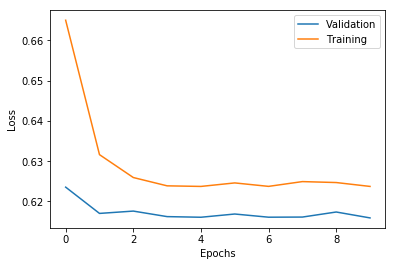

In [20]:
with open('./%s/hist_0.json' % path_info['model_info']['model_dir'], 'r') as f:
    history = json.load(f)
    
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['loss'], label='Training')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Test evauation and train evauation is the numpy array of the shape (number of folds, number of evaluation measures).

In [21]:
test_evaluation

array([[0.619, 0.690, 1.000, 0.000, 0.000],
       [0.593, 0.720, 1.000, 0.000, 0.000],
       [0.650, 0.655, 1.000, 0.000, 0.000],
       [0.587, 0.690, 1.000, 0.000, 0.000],
       [0.608, 0.705, 1.000, 0.000, 0.000]])

In [22]:
train_evaluation

array([[0.622, 0.686, 1.000, 0.000, 0.000],
       [0.593, 0.720, 1.000, 0.000, 0.000],
       [0.613, 0.697, 1.000, 0.000, 0.000],
       [0.594, 0.686, 1.000, 0.000, 0.000],
       [0.625, 0.683, 1.000, 0.000, 0.000]])

## 5. Load the pre-trained network for training

If you have a pre-trianed model, you warm_start next training using the pre-trained weights by setting the `warm_start` option in `training_info` to `True`. The file path of the pre-trained weights passed in the `warm_start_model` option. Below is the example:

In [23]:
warm_start_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
    },
    'training_info': {
        'warm_start':'True',
        'warm_start_model':'./example_result/weight.h5',
        'epochs': '10',
        'batch_size': '50',
        'callbacks': 'ModelCheckpoint',
        'monitor': 'val_loss',
        'mode' : 'min',
        'min_delta': '1e-7',
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [24]:
test_evaluation, train_evaluation, network = deepbiome.deepbiome_train(log, warm_start_network_info, path_info, 
                                                                       number_of_fold=None)

[root    |INFO|deepbiome.py:115] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 1 simulation
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Ge

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s 769us/step - loss: 0.6264 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6162 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 138us/step - loss: 0.6246 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6156 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 152us/step - loss: 0.6226 - binary_accuracy: 0.6844 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6167 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|build_network.py:147] Training end with time 2.9706335067749023!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 4us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.01216745376586914!
[root    |INFO|build_network.py:179] Evaluation: [0.6077973246574402, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 14us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.010446786880493164!
[root    |INFO|build_network.py:179] Evaluation: [0.608977735042572, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.626851797103882
[root    |INFO|deepbiome.py:200] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 2 simulation
[root    |INFO|build_network.py:521] ------------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 856us/step - loss: 0.5983 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5809 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 135us/step - loss: 0.5976 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5766 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 151us/step - loss: 0.5978 - binary_accuracy: 0.7156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5759 - val_binary_accuracy: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|build_network.py:147] Training end with time 2.6066670417785645!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008038043975830078!
[root    |INFO|build_network.py:179] Evaluation: [0.5931535363197327, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 8us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.009198188781738281!
[root    |INFO|build_network.py:179] Evaluation: [0.5931748747825623, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.5099010467529297
[root    |INFO|deepbiome.py:200] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 3 simulation
[root    |INFO|build_network.py:521] ----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 841us/step - loss: 0.6138 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6109 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 132us/step - loss: 0.6140 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6112 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 156us/step - loss: 0.6138 - binary_accuracy: 0.6969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6109 - val_binary_accuracy: 0.7000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|build_network.py:147] Training end with time 2.8092546463012695!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008527040481567383!
[root    |INFO|build_network.py:179] Evaluation: [0.6130011081695557, 0.6974999904632568, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 12us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008930444717407227!
[root    |INFO|build_network.py:179] Evaluation: [0.6493600606918335, 0.6549999713897705, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.428178071975708
[root    |INFO|deepbiome.py:200] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------4 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 4 simulation
[root    |INFO|build_network.py:521] -----------------------------------------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 1ms/step - loss: 0.5932 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5896 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 502us/step - loss: 0.5770 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5793 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 146us/step - loss: 0.5591 - binary_accuracy: 0.6859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.5682 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|build_network.py:147] Training end with time 4.435325384140015!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_3.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_3.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_3.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 4us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.010611295700073242!
[root    |INFO|build_network.py:179] Evaluation: [0.4794653058052063, 0.7200000286102295, 1.0, 0.10756972432136536, 0.3279782235622406]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 10us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008459091186523438!
[root    |INFO|build_network.py:179] Evaluation: [0.45449164509773254, 0.7200000286102295, 1.0, 0.09677419066429138, 0.3110854923725128]
[root    |INFO|deepbiome.py:199] Compute time : 5.07786226272583
[root    |INFO|deepbiome.py:200] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------5 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 5 simulation
[root    |INFO|build_network.py:521] ----------------------------

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s 776us/step - loss: 0.6277 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6167 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 123us/step - loss: 0.6281 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6162 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 249us/step - loss: 0.6274 - binary_accuracy: 0.6797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - gmeasure: 0.0000e+00 - val_loss: 0.6164 - val_binary_accuracy: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|build_network.py:147] Training end with time 2.8508307933807373!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_4.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_4.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_4.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008268117904663086!
[root    |INFO|build_network.py:179] Evaluation: [0.6248783469200134, 0.6825000047683716, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 9us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.007416963577270508!
[root    |INFO|build_network.py:179] Evaluation: [0.6074368953704834, 0.7049999833106995, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.8774726390838623
[root    |INFO|deepbiome.py:200] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:211] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:212] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:213]       mean : [0.584 0.701 1.000 0.022 0.066]
[root    |INFO|deepbiome.py:214]        std : [0.053 0.016 0.000 0.043 0.131]
[root    |INFO|deepbiome.py:215] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:216] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:217]       mean : [0.583 0.

Let's check the history plot again.

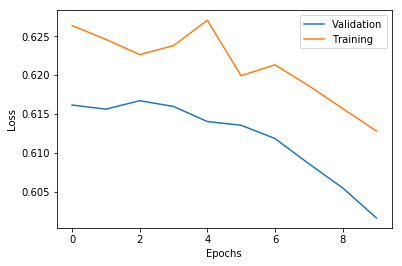

In [25]:
with open('./%s/hist_0.json' % path_info['model_info']['model_dir'], 'r') as f:
    history = json.load(f)
    
plt.plot(history['val_loss'], label='Validation')
plt.plot(history['loss'], label='Training')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Load the pre-trained network for testing

To test the trained model, we can use the `deepbiome_test` function. 

If you use the index file (`idx_path`), this function provides the evaluation using the test index (index set not included in the index file) for each fold. If not, this function provides the evaluation using the whole samples. 

If `number_of_fold` is set to `k`, the function will test the model only with first `k` folds.

We can use the testing metrics different with the training. In the example below, we additionally used `AUC` metric.

In [26]:
test_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [27]:
test_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

In [28]:
evaluation = deepbiome.deepbiome_test(log, test_network_info, test_path_info, number_of_fold=None)

[root    |INFO|deepbiome.py:293] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:325] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:327] -------1 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:338] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:339] Build network for 1 fold testing
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|deepbiome.py:350] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:351] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 594us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.26632118225097656!
[root    |INFO|build_network.py:179] Evaluation: [0.608977735042572, 0.6899999976158142, 1.0, 0.0, 0.0, 0.6397265195846558]
[root    |INFO|deepbiome.py:356] 
[root    |INFO|deepbiome.py:357] Compute time : 0.8801772594451904
[root    |INFO|deepbiome.py:358] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:327] -------2 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:338] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:339] Build network for 2 fold testing
[root    |INFO|build_network.py:521] -----

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|deepbiome.py:350] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:351] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 542us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.3015158176422119!
[root    |INFO|build_network.py:179] Evaluation: [0.5931748747825623, 0.7200000286102295, 1.0, 0.0, 0.0, 0.4986979067325592]
[root    |INFO|deepbiome.py:356] 
[root    |INFO|deepbiome.py:357] Compute time : 0.8466978073120117
[root    |INFO|deepbiome.py:358] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:327] -------3 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:338] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:339] Build network for 3 fold testing
[root    |INFO|build_network.py:521] -----

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

[root    |INFO|build_network.py:670] ------------------------------------------------------------------------------------------



input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0         
_________________________________________________________________
l4_dense (Dense_with_tree)   (None, 9)                 162       
_________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|deepbiome.py:350] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:351] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 501us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.2538328170776367!
[root    |INFO|build_network.py:179] Evaluation: [0.6493600606918335, 0.6549999713897705, 1.0, 0.0, 0.0, 0.4984511435031891]
[root    |INFO|deepbiome.py:356] 
[root    |INFO|deepbiome.py:357] Compute time : 0.9096362590789795
[root    |INFO|deepbiome.py:358] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:327] -------4 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:338] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:339] Build network for 4 fold testing
[root    |INFO|build_network.py:521] -----

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|deepbiome.py:350] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:351] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 432us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.25353074073791504!
[root    |INFO|build_network.py:179] Evaluation: [0.45449164509773254, 0.7200000286102295, 1.0, 0.09677419066429138, 0.3110854923725128, 0.8937587738037109]
[root    |INFO|deepbiome.py:356] 
[root    |INFO|deepbiome.py:357] Compute time : 1.1399180889129639
[root    |INFO|deepbiome.py:358] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:327] -------5 fold test start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:338] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:339] Build network for 5 fold testing
[root    

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|deepbiome.py:350] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:351] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 375us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.25330519676208496!
[root    |INFO|build_network.py:179] Evaluation: [0.6074368953704834, 0.7049999833106995, 1.0, 0.0, 0.0, 0.6676283478736877]
[root    |INFO|deepbiome.py:356] 
[root    |INFO|deepbiome.py:357] Compute time : 0.8034312725067139
[root    |INFO|deepbiome.py:358] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:367] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:368] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure' 'auc']
[root    |INFO|deepbiome.py:369]       mean : [0.583 0.698 1.000 0.019 0.062 0.640]
[root    |INFO|deepbiome.py:370]        std : [0.067 0.024 0.000 0.039 0.124 0.145]
[root    |INFO|deepbiome.py:371] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:372] Total Computing Ended
[root    |INFO|deepbiome.py:373] --------------

This function provides the evaluation result as a numpy array with a shape of (number of folds, number of evaluation measures).

In [29]:
print('      %s' % ''.join(['%16s'%'loss']+ ['%16s'%s.strip() for s in test_network_info['model_info']['metrics'].split(',')]))
print('Mean: %s' % ''.join(['%16.4f'%v for v in np.mean(evaluation, axis=0)]))
print('Std : %s' % ''.join(['%16.4f'%v for v in np.std(evaluation, axis=0)]))

                  loss binary_accuracy     sensitivity     specificity        gmeasure             auc
Mean:           0.5827          0.6980          1.0000          0.0194          0.0622          0.6397
Std :           0.0668          0.0242          0.0000          0.0387          0.1244          0.1450


## 7. Load the pre-trained network for prediction

If you want to predict using the pre-trained model, you can use the `deepbiome_prediction` function. If `number_of_fold` is setted as `k`, the function will predict only with first `k` folds sample's outputs. 

If `change_weight_for_each_fold` is set as `False`, the function will predict the output of every folds by same weight from the given path. If `change_weight_for_each_fold` is set as `True`, the function will predict the output of by each fold weight.

If 'get_y=True', the function will provide a list of tuples (prediction, true output) as a output with the shape of `(n_samples, 2, n_classes)`. If 'get_y=False', the function will provide predictions only. The output will have the shape of `(n_samples, n_classes)`.

### 7.1 Prediction with fixed weight

If we want to predict new data from one pre-trained model, we can use the option below. We fixed the weight `weight_0.h5` for predicting the whole samples from `onefile_x.csv` (without using index file).

In [30]:
prediction_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [31]:
prediction_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'model_dir': './example_result/',
        'weight': 'weight_0.h5'
    }
}

In [32]:
prediction = deepbiome.deepbiome_prediction(log, prediction_network_info, prediction_path_info,
                                            num_classes = 1, number_of_fold=None)

[root    |INFO|deepbiome.py:450] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:480] -------1 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:498] -----------------------------------------------------------------
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Genus', 'Family', 'Order', 'Class', 'Phylum']
[root

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|deepbiome.py:509] -----------------------------------------------------------------
[root    |INFO|build_network.py:193] Prediction start!


1000/1000 [==============================] - 0s 51us/step


[root    |INFO|build_network.py:198] Prediction end with time 0.05417037010192871!
[root    |INFO|deepbiome.py:513] Compute time : 0.5956833362579346
[root    |INFO|deepbiome.py:514] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:519] Total Computing Ended
[root    |INFO|deepbiome.py:520] -----------------------------------------------------------------


In [33]:
prediction.shape

(1, 1000, 1)

In [34]:
prediction[0,:10]

array([[0.684],
       [0.688],
       [0.676],
       [0.662],
       [0.674],
       [0.739],
       [0.688],
       [0.670],
       [0.669],
       [0.667]], dtype=float32)

### 7.2 Prediction with each fold weight

If we want to predict the cross-validation outputs, we can use the option belows.

The example below shows how to predict the 5-fold cross-validation outputs. (If we use the leave-one-out-cross-validation (LOOCV) for training, we can predict the LOOCV outputs by same way.)
We set `idx_path` for using the index file `onefile_idx.csv` to predict only the test set for each fold.

In [35]:
prediction_network_info = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'lr': '0.01',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure, auc',
        'network_class': 'DeepBiomeNetwork',
        'normalizer': 'normalize_minmax',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [36]:
prediction_path_info = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    }
}

To predict the CV outputs from each fold, we set `change_weight_for_each_fold = True`. Also, we set `get_y=True` to get the paired output of each prediction too.

In [37]:
prediction = deepbiome.deepbiome_prediction(log, prediction_network_info, prediction_path_info,
                                            num_classes = 1, number_of_fold=None, 
                                            change_weight_for_each_fold = True, 
                                            get_y=True)

[root    |INFO|deepbiome.py:450] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:480] -------1 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:498] -----------------------------------------------------------------
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Genus', 'Family', 'Order', 'Class', 'Phylum']
[root

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|deepbiome.py:509] -----------------------------------------------------------------
[root    |INFO|build_network.py:193] Prediction start!


200/200 [==============================] - 0s 147us/step


[root    |INFO|build_network.py:198] Prediction end with time 0.032140254974365234!
[root    |INFO|deepbiome.py:513] Compute time : 0.6093075275421143
[root    |INFO|deepbiome.py:514] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:480] -------2 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:498] -----------------------------------------------------------------
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepb

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|deepbiome.py:509] -----------------------------------------------------------------
[root    |INFO|build_network.py:193] Prediction start!


200/200 [==============================] - 0s 219us/step


[root    |INFO|build_network.py:198] Prediction end with time 0.0466768741607666!
[root    |INFO|deepbiome.py:513] Compute time : 0.6837012767791748
[root    |INFO|deepbiome.py:514] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:480] -------3 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:498] -----------------------------------------------------------------
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbio

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|deepbiome.py:509] -----------------------------------------------------------------
[root    |INFO|build_network.py:193] Prediction start!


200/200 [==============================] - 0s 282us/step


[root    |INFO|build_network.py:198] Prediction end with time 0.05935072898864746!
[root    |INFO|deepbiome.py:513] Compute time : 0.673020601272583
[root    |INFO|deepbiome.py:514] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:480] -------4 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:498] -----------------------------------------------------------------
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbio

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|deepbiome.py:509] -----------------------------------------------------------------
[root    |INFO|build_network.py:193] Prediction start!


200/200 [==============================] - 0s 516us/step


[root    |INFO|build_network.py:198] Prediction end with time 0.10687398910522461!
[root    |INFO|deepbiome.py:513] Compute time : 0.9963078498840332
[root    |INFO|deepbiome.py:514] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:480] -------5 th repeatition prediction start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:498] -----------------------------------------------------------------
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbi

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure, auc
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|deepbiome.py:509] -----------------------------------------------------------------
[root    |INFO|build_network.py:193] Prediction start!


200/200 [==============================] - 0s 723us/step


[root    |INFO|build_network.py:198] Prediction end with time 0.1472012996673584!
[root    |INFO|deepbiome.py:513] Compute time : 0.9382455348968506
[root    |INFO|deepbiome.py:514] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:519] Total Computing Ended
[root    |INFO|deepbiome.py:520] -----------------------------------------------------------------


We gathered the outputs from each fold. 

In [38]:
prediction = np.vstack(prediction)

Since we set the option `get_y=True`, the output has the shape of `(n_samples, 2, n_classes)`. With this options, we can get the CV predictions and the true output of each predictions.

Now, we can calculate the CV performance by the CV predictions.

In [39]:
predict_output = prediction[:,0]
true_output = prediction[:,1]

log.info('Shape of the predict function output: %s' % str(prediction.shape))
log.info('Shape of the prediction: %s' % str(predict_output.shape))
log.info('Shape of the true_output for each prediction: %s' % str(true_output.shape))

[root    |INFO|<ipython-input-39-edc88a58497e>:4] Shape of the predict function output: (1000, 2, 1)
[root    |INFO|<ipython-input-39-edc88a58497e>:5] Shape of the prediction: (1000, 1)
[root    |INFO|<ipython-input-39-edc88a58497e>:6] Shape of the true_output for each prediction: (1000, 1)


In [40]:
log.info('CV accuracy: %6.3f' % np.mean((predict_output >= 0.5) ==  true_output))

[root    |INFO|<ipython-input-40-ecaee2413087>:1] CV accuracy:  0.698


## 8. Load trained weight matrix

The `deepbiome_get_trained_weight` function convert the trained weight `*.h5` saved from the `deepbiome_train` to a list of pandas dataframe.
In this exampe, the list has numpy array of weights from 6 layers. (`[genus to family, family to order, order to Class, class to phylum, phylum to output]`)

In [41]:
weight_path = '%s/%s' % (path_info['model_info']['model_dir'], 'weight_0.h5')
trained_weight_list = deepbiome.deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1, weight_path=weight_path)
log.info(len(trained_weight_list))

[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:529] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:537]      Genus: 48
[root    |INFO|build_network.py:537]     Family: 40
[root    |INFO|build_network.py:537]      Order: 23
[root    |INFO|build_network

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48)                0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 40)                1960      
_________________________________________________________________
l1_activation (Activation)   (None, 40)                0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 23)                943       
_________________________________________________________________
l2_activation (Activation)   (None, 23)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 17)                408       
_________________________________________________________________
l3_activation (Activation)   (None, 17)                0   

[root    |INFO|<ipython-input-41-9505ee8dcaa8>:3] 5


First weight between the `genus` and `family` layers has the shape of `(number of genus = 48, number of family = 40)`

In [42]:
log.info(trained_weight_list[0].shape)

[root    |INFO|<ipython-input-42-c71fa46ab178>:1] (48, 40)


In [43]:
trained_weight_list[0]

,Streptococcaceae,Cellulomonadaceae,Veillonellaceae,Actinomycetaceae,Flavobacteriaceae,Prevotellaceae,Porphyromonadaceae,Clostridiales_Incertae_Sedis_XI,Fusobacteriaceae,Propionibacteriaceae,...,Methylobacteriaceae,OD1_genera_incertae_sedis,Microbacteriaceae,Sphingomonadaceae,Bacteroidaceae,Bdellovibrionaceae,Chloroplast,Rhodobacteraceae,Ruminococcaceae,Pseudonocardiaceae
Streptococcus,-0.174,-0.001,-0.003,-0.002,0.001,-0.001,-0.000,0.002,0.002,0.002,...,0.001,-0.002,0.001,0.000,-0.003,0.000,0.003,0.002,-0.002,0.000
Tropheryma,-0.003,-0.248,0.001,0.001,-0.002,-0.001,0.002,0.003,0.006,0.005,...,-0.002,-0.001,0.002,-0.001,-0.007,-0.001,0.003,0.002,-0.002,-0.001
Veillonella,-0.001,-0.002,-0.205,0.002,-0.000,0.002,-0.001,-0.001,0.003,0.005,...,-0.001,0.000,0.001,-0.001,-0.003,-0.002,0.002,0.001,0.002,0.000
Actinomyces,-0.000,0.002,0.001,-0.115,0.002,-0.002,0.001,0.002,0.002,0.005,...,-0.002,0.002,-0.001,-0.002,-0.005,0.003,-0.000,0.000,-0.002,-0.002
Flavobacterium,-0.002,-0.000,0.002,-0.002,-0.049,-0.002,0.001,-0.003,-0.003,0.001,...,-0.001,0.002,-0.001,0.002,-0.001,-0.001,0.002,-0.001,0.001,0.001
Prevotella,-0.001,-0.000,-0.001,-0.002,-0.002,-0.047,0.002,-0.002,-0.002,0.004,...,-0.001,0.002,0.002,-0.001,0.001,0.001,-0.002,0.002,0.000,0.001
Porphyromonas,-0.000,0.003,-0.002,-0.001,0.001,0.001,-0.017,-0.001,-0.001,-0.000,...,-0.001,-0.002,0.000,0.000,0.004,0.000,-0.002,-0.001,-0.002,0.000
Parvimonas,0.002,-0.001,-0.002,-0.001,0.002,-0.000,-0.002,0.263,-0.001,-0.001,...,-0.000,-0.000,-0.000,0.001,-0.000,-0.001,-0.001,0.002,-0.001,0.001
Fusobacterium,-0.000,-0.000,-0.001,-0.000,0.000,0.001,-0.001,0.000,0.265,-0.001,...,-0.002,-0.002,0.000,0.002,-0.000,-0.001,0.002,0.001,-0.001,0.002
Propionibacterium,0.001,0.001,-0.001,0.002,-0.001,0.003,0.000,-0.006,-0.004,-2.003,...,0.000,-0.000,-0.001,-0.001,0.008,-0.002,-0.000,-0.000,-0.002,0.001


## 9. Taxa selection performance

If we know the true disease path, we can calculate the taxa selection performance by `deepbiome_taxa_selection_performance` funciton. First, we prepared the true weight list based on the true disease path. For each fold, we prepared 4 weights from the 5 layers (`[genus to family, family to order, order to Class, class to phylum]`). An example of the list of the true weights from each fold is as follow:

In [44]:
true_tree_weight_list = np.load(resource_filename('deepbiome', 'tests/data/true_weight_list.npy'), allow_pickle=True)
log.info(true_tree_weight_list.shape)

[root    |INFO|<ipython-input-44-7f16305fbcb7>:2] (5, 4)


The first weight between the genus and family layers for first epoch has the shape below:

In [45]:
log.info(true_tree_weight_list[0][0].shape)

[root    |INFO|<ipython-input-45-7f1406e7d9a7>:1] (48, 40)


We will calculate the taxa selection performance of the trained weight below:

In [46]:
trained_weight_path_list = ['%s/weight_%d.h5' % (path_info['model_info']['model_dir'], i) for i in range(5)]
trained_weight_path_list

['./example_result//weight_0.h5',
 './example_result//weight_1.h5',
 './example_result//weight_2.h5',
 './example_result//weight_3.h5',
 './example_result//weight_4.h5']

This is the summary of the taxa selection accuracy of trained weights from each fold.

In [47]:
summary = deepbiome.deepbiome_taxa_selection_performance(log, network_info, path_info, num_classes=1, 
                                                         true_tree_weight_list=true_tree_weight_list, 
                                                         trained_weight_path_list = trained_weight_path_list)

[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result//weight_0.h5 
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result//weight_1.h5 
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result//weight_2.h5 
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result//weight_3.h5 
[root    |INFO|build_network.py:87] Load trained model weight at ./example_result//weight_4.h5 


In [48]:
summary

,Model,PhyloTree,No. true taxa,No. total taxa,Sensitivity_mean,Sensitivity_std,Specificity_mean,Specificity_std,Gmeasure_mean,Gmeasure_std,Accuracy_mean,Accuracy_std
0,./example_result/,Genus,31,48,0.948,0.044,0.983,0.014,0.965,0.021,0.982,0.013
1,,Family,23,40,0.991,0.017,0.973,0.011,0.982,0.008,0.973,0.010
2,,Order,9,23,0.978,0.044,0.953,0.015,0.965,0.021,0.954,0.015
3,,Class,7,17,0.971,0.057,0.925,0.018,0.948,0.037,0.927,0.020


## 10. Draw phylogenetic tree

The `deepbiome_get_trained_weight` function draw phylogenetic tree for the `DeepBiome` network. This function implemented `ete3` library (link TBD).

If we turn on the `tree_weight_on` option, the function shows the amount and direction of the tree weights for each edge by circle size and color. For this option, we have to feed a list of pandas dataframe of the tree weights obtained from `deepbiome_get_trained_weight` function to `tree_weight` argument.
In this example, we used the 5 lists of weights from 5-fold cross validation obtained from `deepbiome_get_trained_weight` function.
For each layer, we first averaged 5 weights from 5 fold CV.

In [49]:
tot_trained_weight_list = []
for fold in range(5):
    weight_path = '%s/%s' % (path_info['model_info']['model_dir'], 'weight_%d.h5' % fold)
    trained_weight_list = deepbiome.deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1,
                                                                 weight_path=weight_path, verbose=False)
    tot_trained_weight_list.append(trained_weight_list)
    
trained_weight_list = []
for i in range(len(tot_trained_weight_list[0])):
    level_weights = tot_trained_weight_list[0][i]
    for j in range(1,len(tot_trained_weight_list)):
        level_weights +=tot_trained_weight_list[j][i]
    level_weights /= len(tot_trained_weight_list)
    trained_weight_list.append(level_weights)

Now, we can draw the phylogenetic tree with trained weights. For using the trained weights, __`tree_level_list`, the list of names for each level, should be same as the name of each level in the trained weight list.__
We used `file_name='%%inline'` option to show the tree in the jupyter notebook. To specify the background color for each phylum, we turned on the `phylum_background_color_on` option and used `phylum_color` list.

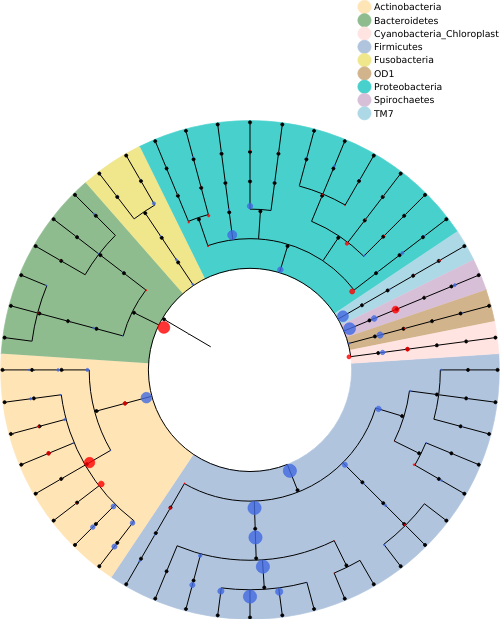

In [50]:
phylum_color = ['lightsteelblue', 
                 'moccasin',
                 'darkseagreen',
                 'khaki',
                 'mediumturquoise',
                 'lightblue',
                 'thistle',
                 'tan',
                 'mistyrose',
                ]

img = deepbiome.deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
                                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, 
                                                 arc_start=0, arc_span=360, 
                                                 node_name_on=False, name_fsize=10, 
                                                 tree_weight_on=True, tree_weight=trained_weight_list, 
                                                 tree_level_list = ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Disease'],
                                                 weight_opacity=0.8, weight_max_radios=10, 
                                                 phylum_background_color_on=True, phylum_color=phylum_color, phylum_color_legend=True,
                                                 verbose=False)
img

We can show the name of each leaf node in the phylogenetic tree by turn on the `node_name_on` option.

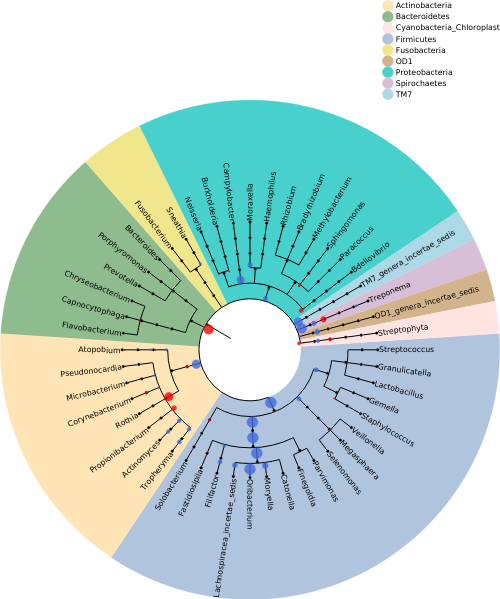

In [51]:
img = deepbiome.deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
                                                 file_name='%%inline', img_w=500,
                                                 branch_vertical_margin=20, arc_start=0, arc_span=360,
                                                 node_name_on=True, name_fsize=20, 
                                                 tree_weight_on=True, tree_weight=trained_weight_list,
                                                 tree_level_list = ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Disease'],
                                                 weight_opacity=0.8, weight_max_radios=20, 
                                                 phylum_background_color_on=True, phylum_color=phylum_color, phylum_color_legend=True, 
                                                 verbose=False)
img

If we want to save the figure as `png` or `jpg`, we can change `file_name` option.

In [52]:
img = deepbiome.deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
                                                 file_name='tree.png', img_w=500,
                                                 branch_vertical_margin=20, arc_start=0, arc_span=360,
                                                 node_name_on=True, name_fsize=20, 
                                                 tree_weight_on=True, tree_weight=trained_weight_list,
                                                 tree_level_list = ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Disease'],
                                                 weight_opacity=0.8, weight_max_radios=20, 
                                                 phylum_background_color_on=True, phylum_color=phylum_color, phylum_color_legend=True, 
                                                 verbose=False)

We can check that the tree image saved in `tree.png`.

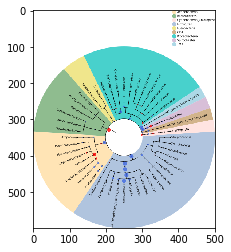

In [53]:
img = plt.imread('tree.png')
plt.imshow(img)
plt.show()

## 11. Using covariates

We can use covariates for training the DeepBiome network.

Below is an example of the input files for the continuous covariates.

In [54]:
pd.read_csv(resource_filename('deepbiome', 'tests/data/ages.csv'))

,ages
0,59.000
1,45.000
2,42.000
3,50.000
4,69.000
5,37.000
6,66.000
7,75.000
8,32.000
9,72.000


Below is an example of the input files for the categorical covariates. We assume that the file contains all of the catetogories for one-hot encoding.

In [55]:
pd.read_csv(resource_filename('deepbiome', 'tests/data/gender.csv'))

,gender
0,1
1,0
2,1
3,1
4,1
5,0
6,1
7,1
8,0
9,0


In [56]:
pd.read_csv(resource_filename('deepbiome', 'tests/data/ethnicity.csv'))

,ethnicity
0,4
1,0
2,0
3,4
4,4
5,2
6,3
7,0
8,2
9,5


For using the covariates, we have to set the `covariates_info` field in the configuration for the path informations. If we don't specify the `covariates_info`, than the DeepBiome will train the model without any covariates.

In [57]:
network_info_with_covariates = {
    'architecture_info': {
        'batch_normalization': 'False',
        'drop_out': '0',
        'weight_initial': 'glorot_uniform',
        'weight_l1_penalty':'0.',
        'weight_decay': 'phylogenetic_tree',
    },
    'model_info': {
        'lr': '0.01',
        'decay': '0.001',
        'loss': 'binary_crossentropy',
        'metrics': 'binary_accuracy, sensitivity, specificity, gmeasure',
        'taxa_selection_metrics': 'sensitivity, specificity, gmeasure, accuracy',
        'network_class': 'DeepBiomeNetwork',
        'optimizer': 'adam',
        'reader_class': 'MicroBiomeClassificationReader',
        'normalizer': 'normalize_minmax',
    },
    'training_info': {
        'epochs': '10',
        'batch_size': '50', 
        'callbacks': 'ModelCheckpoint',
        'monitor': 'val_loss',
        'mode' : 'min',
        'min_delta': '1e-7',
    },
    'validation_info': {
        'batch_size': 'None', 
        'validation_size': '0.2'
    },
    'test_info': {
        'batch_size': 'None'
    }
}

In [58]:
path_info_with_covariates = {
    'data_info': {
        'data_path': resource_filename('deepbiome', 'tests/data'),
        'idx_path': resource_filename('deepbiome', 'tests/data/onefile_idx.csv'),
        'tree_info_path': resource_filename('deepbiome', 'tests/data/genus48_dic.csv'),
        'x_path': 'onefile_x.csv',
        'y_path': 'classification_y.csv'
    },
    'model_info': {
        'evaluation': 'eval.npy',
        'history': 'hist.json',
        'model_dir': './example_result/',
        'weight': 'weight.h5'
    },
    'covariates_info':{
        'continuous_variables':','.join([resource_filename('deepbiome', 'tests/data/ages.csv'),
                                         resource_filename('deepbiome', 'tests/data/weights.csv')]),
        'categorical_variables':','.join([resource_filename('deepbiome', 'tests/data/gender.csv'),
                                         resource_filename('deepbiome', 'tests/data/ethnicity.csv')]),
    }
}

We can use the same `deepbiome_train` function when we train the network with covariates.

In [59]:
test_evaluation_with_cov, train_evaluation_with_cov, network_with_cov = deepbiome.deepbiome_train(log, network_info_with_covariates, 
                                                                                                  path_info_with_covariates,
                                                                                                  number_of_fold=None)

[root    |INFO|deepbiome.py:115] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:153] -------1 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 1 simulation
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from /DATA/home/muha/github_repos/deepbiome/deepbiome/tests/data/genus48_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Ge

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 48)           0                                            
__________________________________________________________________________________________________
l1_dense (Dense_with_tree)      (None, 40)           1960        input[0][0]                      
__________________________________________________________________________________________________
l1_activation (Activation)      (None, 40)           0           l1_dense[0][0]                   
__________________________________________________________________________________________________
l2_dense (Dense_with_tree)      (None, 23)           943         l1_activation[0][0]              
____________________________________________________________________________________________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 1 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 1ms/step - loss: 11.0308 - binary_accuracy: 0.3156 - sensitivity: 0.0000e+00 - specificity: 1.0000 - gmeasure: 0.0000e+00 - val_loss: 11.1819 - val_binary_accuracy: 0.3063 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_gmeasure: 0.0000e+00
Epoch 2/10
640/640 [==============================] - 0s 101us/step - loss: 11.0308 - binary_accuracy: 0.3156 - sensitivity: 0.0000e+00 - specificity: 1.0000 - gmeasure: 0.0000e+00 - val_loss: 11.1819 - val_binary_accuracy: 0.3063 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 101us/step - loss: 11.0308 - binary_accuracy: 0.3156 - sensitivity: 0.0000e+00 - specificity: 1.0000 - gmeasure: 0.0000e+00 - val_loss: 11.1819 - val_binary_accuracy: 0.3063 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_gmeasure: 0.0000e+00
Epoch 4/10
640

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_0.h5 
[root    |INFO|build_network.py:147] Training end with time 3.0836904048919678!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_0.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_0.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_0.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.010069608688354492!
[root    |INFO|build_network.py:179] Evaluation: [11.061043739318848, 0.3137499988079071, 0.0, 1.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008058786392211914!
[root    |INFO|build_network.py:179] Evaluation: [11.121485710144043, 0.3100000023841858, 0.0, 1.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.6023569107055664
[root    |INFO|deepbiome.py:200] 1 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------2 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 2 simulation
[root    |INFO|build_network.py:521] ----------------------------------------------------------

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 48)           0                                            
__________________________________________________________________________________________________
l1_dense (Dense_with_tree)      (None, 40)           1960        input[0][0]                      
__________________________________________________________________________________________________
l1_activation (Activation)      (None, 40)           0           l1_dense[0][0]                   
__________________________________________________________________________________________________
l2_dense (Dense_with_tree)      (None, 23)           943         l1_activation[0][0]              
____________________________________________________________________________________________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 2 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 782us/step - loss: 2.5421 - binary_accuracy: 0.5859 - sensitivity: 0.7057 - specificity: 0.2490 - gmeasure: 0.3932 - val_loss: 1.6270 - val_binary_accuracy: 0.6250 - val_sensitivity: 0.7962 - val_specificity: 0.2233 - val_gmeasure: 0.4150
Epoch 2/10
640/640 [==============================] - 0s 116us/step - loss: 1.9945 - binary_accuracy: 0.5688 - sensitivity: 0.6823 - specificity: 0.2938 - gmeasure: 0.4414 - val_loss: 1.2290 - val_binary_accuracy: 0.6062 - val_sensitivity: 0.7127 - val_specificity: 0.3178 - val_gmeasure: 0.4747
Epoch 3/10
640/640 [==============================] - 0s 115us/step - loss: 1.4228 - binary_accuracy: 0.5906 - sensitivity: 0.7194 - specificity: 0.2600 - gmeasure: 0.4167 - val_loss: 0.8595 - val_binary_accuracy: 0.6438 - val_sensitivity: 0.8164 - val_specificity: 0.2233 - val_gmeasure: 0.4195
Epoch 4/10
640/640 [==============================] - 0s 110us/ste

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_1.h5 
[root    |INFO|build_network.py:147] Training end with time 2.6916720867156982!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_1.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_1.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_1.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.008504152297973633!
[root    |INFO|build_network.py:179] Evaluation: [0.6034644246101379, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 9us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.007249355316162109!
[root    |INFO|build_network.py:179] Evaluation: [0.6046146154403687, 0.7200000286102295, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.215890407562256
[root    |INFO|deepbiome.py:200] 2 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------3 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 3 simulation
[root    |INFO|build_network.py:521] -----------------------------------------------------------

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 48)           0                                            
__________________________________________________________________________________________________
l1_dense (Dense_with_tree)      (None, 40)           1960        input[0][0]                      
__________________________________________________________________________________________________
l1_activation (Activation)      (None, 40)           0           l1_dense[0][0]                   
__________________________________________________________________________________________________
l2_dense (Dense_with_tree)      (None, 23)           943         l1_activation[0][0]              
____________________________________________________________________________________________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 3 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s 698us/step - loss: 4.9752 - binary_accuracy: 0.3828 - sensitivity: 0.2109 - specificity: 0.8032 - gmeasure: 0.2862 - val_loss: 1.6229 - val_binary_accuracy: 0.5813 - val_sensitivity: 0.6279 - val_specificity: 0.3807 - val_gmeasure: 0.4665
Epoch 2/10
640/640 [==============================] - 0s 105us/step - loss: 1.8461 - binary_accuracy: 0.6562 - sensitivity: 0.8684 - specificity: 0.1641 - gmeasure: 0.3599 - val_loss: 1.8489 - val_binary_accuracy: 0.6812 - val_sensitivity: 0.9384 - val_specificity: 0.1234 - val_gmeasure: 0.2155
Epoch 3/10
640/640 [==============================] - 0s 96us/step - loss: 1.6691 - binary_accuracy: 0.6375 - sensitivity: 0.8160 - specificity: 0.2189 - gmeasure: 0.3934 - val_loss: 1.4692 - val_binary_accuracy: 0.5625 - val_sensitivity: 0.6009 - val_specificity: 0.4016 - val_gmeasure: 0.4711
Epoch 4/10
640/640 [==============================] - 0s 116us/step

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_2.h5 
[root    |INFO|build_network.py:147] Training end with time 2.9351305961608887!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_2.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_2.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_2.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 3us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.0087738037109375!
[root    |INFO|build_network.py:179] Evaluation: [0.6114577054977417, 0.6949999928474426, 0.9731183052062988, 0.05371900647878647, 0.22863715887069702]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 41us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.014694690704345703!
[root    |INFO|build_network.py:179] Evaluation: [0.6872313022613525, 0.6100000143051147, 0.9312977194786072, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 3.4203402996063232
[root    |INFO|deepbiome.py:200] 3 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------4 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 4 simulation
[root    |INFO|build_network.py:521] -------------------------------------------

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 48)           0                                            
__________________________________________________________________________________________________
l1_dense (Dense_with_tree)      (None, 40)           1960        input[0][0]                      
__________________________________________________________________________________________________
l1_activation (Activation)      (None, 40)           0           l1_dense[0][0]                   
__________________________________________________________________________________________________
l2_dense (Dense_with_tree)      (None, 23)           943         l1_activation[0][0]              
____________________________________________________________________________________________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 4 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 1s 785us/step - loss: 0.8356 - binary_accuracy: 0.5906 - sensitivity: 0.7687 - specificity: 0.2441 - gmeasure: 0.3609 - val_loss: 0.6479 - val_binary_accuracy: 0.6875 - val_sensitivity: 0.9545 - val_specificity: 0.0882 - val_gmeasure: 0.2000
Epoch 2/10
640/640 [==============================] - 0s 377us/step - loss: 0.6636 - binary_accuracy: 0.6625 - sensitivity: 0.9362 - specificity: 0.0742 - gmeasure: 0.1698 - val_loss: 0.6219 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 3/10
640/640 [==============================] - 0s 436us/step - loss: 0.6364 - binary_accuracy: 0.6875 - sensitivity: 1.0000 - specificity: 0.0059 - gmeasure: 0.0213 - val_loss: 0.6247 - val_binary_accuracy: 0.6875 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_gmeasure: 0.0000e+00
Epoch 4/10
640/640 [==============================

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_3.h5 
[root    |INFO|build_network.py:147] Training end with time 3.7450311183929443!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_3.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_3.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_3.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 4us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.011616230010986328!
[root    |INFO|build_network.py:179] Evaluation: [0.6179130673408508, 0.6862499713897705, 1.0, 0.0, 0.0]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 11us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.0076541900634765625!
[root    |INFO|build_network.py:179] Evaluation: [0.6171166300773621, 0.6899999976158142, 1.0, 0.0, 0.0]
[root    |INFO|deepbiome.py:199] Compute time : 4.296782732009888
[root    |INFO|deepbiome.py:200] 4 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:153] -------5 simulation start!----------------------------------
[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|deepbiome.py:164] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:165] Build network for 5 simulation
[root    |INFO|build_network.py:521] ----------------------------------------------------------

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 48)           0                                            
__________________________________________________________________________________________________
l1_dense (Dense_with_tree)      (None, 40)           1960        input[0][0]                      
__________________________________________________________________________________________________
l1_activation (Activation)      (None, 40)           0           l1_dense[0][0]                   
__________________________________________________________________________________________________
l2_dense (Dense_with_tree)      (None, 23)           943         l1_activation[0][0]              
____________________________________________________________________________________________

[root    |INFO|build_network.py:61] Build Network
[root    |INFO|build_network.py:62] Optimizer = adam
[root    |INFO|build_network.py:63] Loss = binary_crossentropy
[root    |INFO|build_network.py:64] Metrics = binary_accuracy, sensitivity, specificity, gmeasure
[root    |INFO|deepbiome.py:176] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:177] 5 fold computing start!----------------------------------
[root    |INFO|build_network.py:137] Training start!


Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s 712us/step - loss: 2.8599 - binary_accuracy: 0.6828 - sensitivity: 0.9640 - specificity: 0.0585 - gmeasure: 0.1176 - val_loss: 1.2346 - val_binary_accuracy: 0.5437 - val_sensitivity: 0.6156 - val_specificity: 0.3758 - val_gmeasure: 0.4799
Epoch 2/10
640/640 [==============================] - 0s 127us/step - loss: 1.5378 - binary_accuracy: 0.4844 - sensitivity: 0.4592 - specificity: 0.5396 - gmeasure: 0.4676 - val_loss: 1.1423 - val_binary_accuracy: 0.6187 - val_sensitivity: 0.8014 - val_specificity: 0.2035 - val_gmeasure: 0.4001
Epoch 3/10
640/640 [==============================] - 0s 152us/step - loss: 1.2258 - binary_accuracy: 0.6359 - sensitivity: 0.8343 - specificity: 0.2156 - gmeasure: 0.4089 - val_loss: 0.9623 - val_binary_accuracy: 0.5938 - val_sensitivity: 0.7371 - val_specificity: 0.3243 - val_gmeasure: 0.4863
Epoch 4/10
640/640 [==============================] - 0s 140us/ste

[root    |INFO|build_network.py:87] Load trained model weight at ./example_result/weight_4.h5 
[root    |INFO|build_network.py:147] Training end with time 2.841571569442749!
[root    |INFO|build_network.py:83] Saved trained model weight at ./example_result/weight_4.h5 
[root    |DEBUG|deepbiome.py:185] Save weight at ./example_result/weight_4.h5
[root    |DEBUG|deepbiome.py:188] Save history at ./example_result/hist_4.json
[root    |INFO|build_network.py:173] Evaluation start!


800/800 [==============================] - 0s 9us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.0183563232421875!
[root    |INFO|build_network.py:179] Evaluation: [0.6290234327316284, 0.6800000071525574, 0.9798534512519836, 0.035433072596788406, 0.18633092939853668]
[root    |INFO|build_network.py:173] Evaluation start!


200/200 [==============================] - 0s 37us/step


[root    |INFO|build_network.py:178] Evaluation end with time 0.016957521438598633!
[root    |INFO|build_network.py:179] Evaluation: [0.6027040481567383, 0.6949999928474426, 0.9716312289237976, 0.033898305147886276, 0.18148458003997803]
[root    |INFO|deepbiome.py:199] Compute time : 3.4107158184051514
[root    |INFO|deepbiome.py:200] 5 fold computing end!---------------------------------------------
[root    |INFO|deepbiome.py:211] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:212] Train Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root    |INFO|deepbiome.py:213]       mean : [2.705 0.619 0.791 0.218 0.083]
[root    |INFO|deepbiome.py:214]        std : [4.178 0.153 0.395 0.392 0.103]
[root    |INFO|deepbiome.py:215] -----------------------------------------------------------------
[root    |INFO|deepbiome.py:216] Test Evaluation : ['loss' 'binary_accuracy' 'sensitivity' 'specificity' 'gmeasure']
[root  

The DeepBiome used the covariates at the latest hidden layer just before the last prediction layer (`biome_covariates_concat` layer in the above example).

In [60]:
network_with_cov.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 48)           0                                            
__________________________________________________________________________________________________
l1_dense (Dense_with_tree)      (None, 40)           1960        input[0][0]                      
__________________________________________________________________________________________________
l1_activation (Activation)      (None, 40)           0           l1_dense[0][0]                   
__________________________________________________________________________________________________
l2_dense (Dense_with_tree)      (None, 23)           943         l1_activation[0][0]              
____________________________________________________________________________________________

We can analysis the effects of covariates by checking the trained weights of the last hidden layer.

In [61]:
weight_path = '%s/%s' % (prediction_path_info['model_info']['model_dir'], 'weight_0.h5')
trained_weight_list = deepbiome.deepbiome_get_trained_weight(log, network_info_with_covariates, path_info_with_covariates,
                                                             num_classes=1, weight_path=weight_path, verbose=False)
log.info(len(trained_weight_list))

[root    |INFO|<ipython-input-61-b8f281eeb9fd>:4] 5


In [62]:
trained_weight_list[4]

,0
Firmicutes,0.566
Actinobacteria,0.330
Bacteroidetes,-0.026
Fusobacteria,0.107
Proteobacteria,0.309
TM7,0.340
Spirochaetes,-0.235
OD1,0.142
Cyanobacteria_Chloroplast,-0.331
Ages,-0.398


Below is the phylogenetic tree plot for the network using covariates.

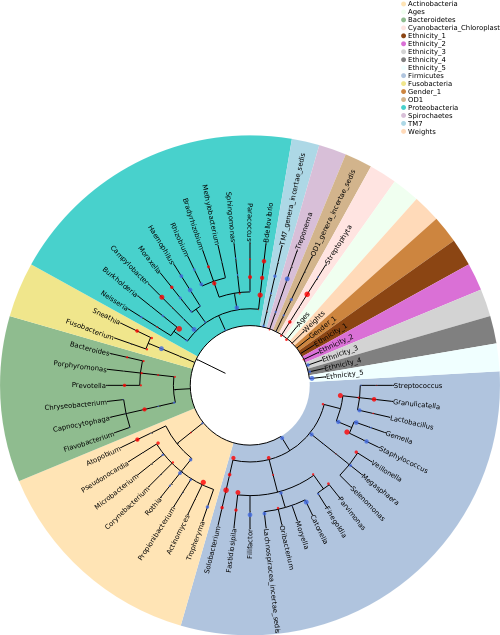

In [63]:
phylum_color = ['lightsteelblue', 
                'moccasin',
                'darkseagreen',
                'khaki',
                'mediumturquoise',
                'lightblue',
                'thistle',
                'tan',
                'mistyrose',
                'honeydew',
                'peachpuff',
                'peru',
                'saddlebrown',
                'orchid',
                'lightgray',
                'gray',
                'azure',
                'lightcyan'
                ]

img = deepbiome.deepbiome_draw_phylogenetic_tree(log, network_info_with_covariates, path_info_with_covariates, num_classes=1,
                                                 file_name='%%inline', img_w=500, branch_vertical_margin=20, 
                                                 arc_start=0, arc_span=360, 
                                                 node_name_on=True, name_fsize=200, 
                                                 tree_weight_on=True, tree_weight=trained_weight_list, 
                                                 tree_level_list = ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Disease'],
                                                 weight_opacity=0.8, weight_max_radios=100, 
                                                 phylum_background_color_on=True, phylum_color=phylum_color, phylum_color_legend=True,
                                                 show_covariates=True,
                                                 verbose=False)
img